In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import matplotlib.pyplot as plt

In [156]:
import numpy as np
import glob
import xarray as xr
import xbudget
import regionate
import xwmt
import xwmb
import xgcm
import cartopy.crs as ccrs
import CM4Xutils #needed to run pip install nc-time-axis
from regionate import MaskRegions, GriddedRegion
import seaborn as sns

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
sns.set_context("notebook")

import pandas as pd

### Request HPC Resources

### Load in data

In [157]:
savedir = "/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/data/model/"

ds_sfc = xr.open_dataset(
        savedir + "Southern_Ocean_Surface_Advection.nc")

ds = xr.open_dataset(
        savedir + "Southern_Ocean_WMT_Budget.nc")

ds["BF_Adv"] = ds["surface_ocean_flux_advective_negative_rhs"]
ds["BF_NonAdv"] = ds["boundary_fluxes"] - ds["BF_Adv"]

### Extract time-mean mass budget

The closed numerical $\lambda$-WMT budget is given in Drake et. al 2024's Equation 43. The budget is given by: 
$$-\partial_t \mathcal{M}_\leq + \mathcal{S}_\leq + \Psi_\leq + \mathcal{G}^{BF}_\leq + \mathcal{G}^{Mix}_\leq + \mathcal{G}^{Spurious}_\leq = 0$$

Here: 
- $ \mathcal{M}(\tilde \lambda, t)_\leq = \int_\Omega \rho dV $ is the set of all waters bounded by a material surface $\tilde \lambda$
-  $\partial_t \mathcal{M}_\leq$ the rate of change of the mass of that water that is bounded by $\tilde \lambda$
    - $\tilde \lambda$ can be a density, so that $\partial_t \mathcal{M}_\leq$ describes the actual mass of waters denser than $\tilde \lambda$
    - When $\tilde \lambda$ is a density surface, $\partial_t \mathcal{M}_\leq > 0$ implies the mass of waters denser than $\tilde \lambda$ is decreasing
- If the region $\omega$ contains open boundaries (i.e. the focus is on a particular ocean), then mass is not conserved. Mass can enter freely via ocean circulation. This movement of mass along the horizontal boundaries is given by $\Psi_\leq$.
- $\mathcal{G}^{BF}_\leq$ is the contribution of mass change from boundary fluxes including mixing processes at the surface, seafloor and sea-ice.
- $\mathcal{G}^{Mix}_\leq$ includes the effects of parameterized mixing
- $\mathcal{G}^{Spurious}_\leq$ includes the effects of spurios mixing, from a models advection scheme. Obtained as a residual. 


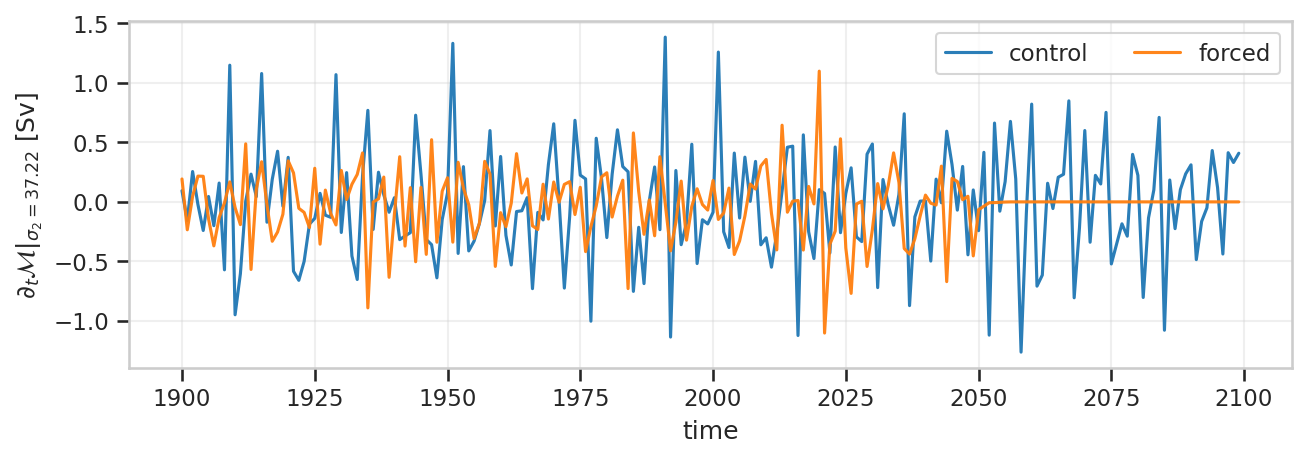

In [158]:
toSv = 1/1035*1e-6
tendencies = toSv * ds.sel(sigma2_l_target = 37.22, method = "nearest").compute()
tendencies = tendencies.groupby("time.year").mean("time")
tendencies = tendencies.sel(year = slice("1900", None))

fig, ax = plt.subplots(1, figsize = (10, 3))
ax.grid(alpha = 0.3)
ax.plot(tendencies.year, tendencies["mass_tendency"].isel(exp = 1), label = "control", linewidth = 1.5, alpha = 0.95)
ax.plot(tendencies.year, tendencies["mass_tendency"].isel(exp = 0), label = "forced", linewidth = 1.5, alpha = 0.95)
ax.legend(ncols = 2)

ax.set_ylabel(r"$\partial_{t} {\mathcal{M}|}_{\sigma_2 = 37.22}$" + " [Sv]")
ax.set_xlabel("time")
ax.tick_params(bottom=True, left=True)

### Checking the total budget

-0.015213297183853926
-0.016459676503973925
0.0012463793201199988
-0.052749418905200046
-0.01442010457134837
-0.03832931433385168
-0.0024092508206311784
-0.003699852672402164
0.0012906018517709855


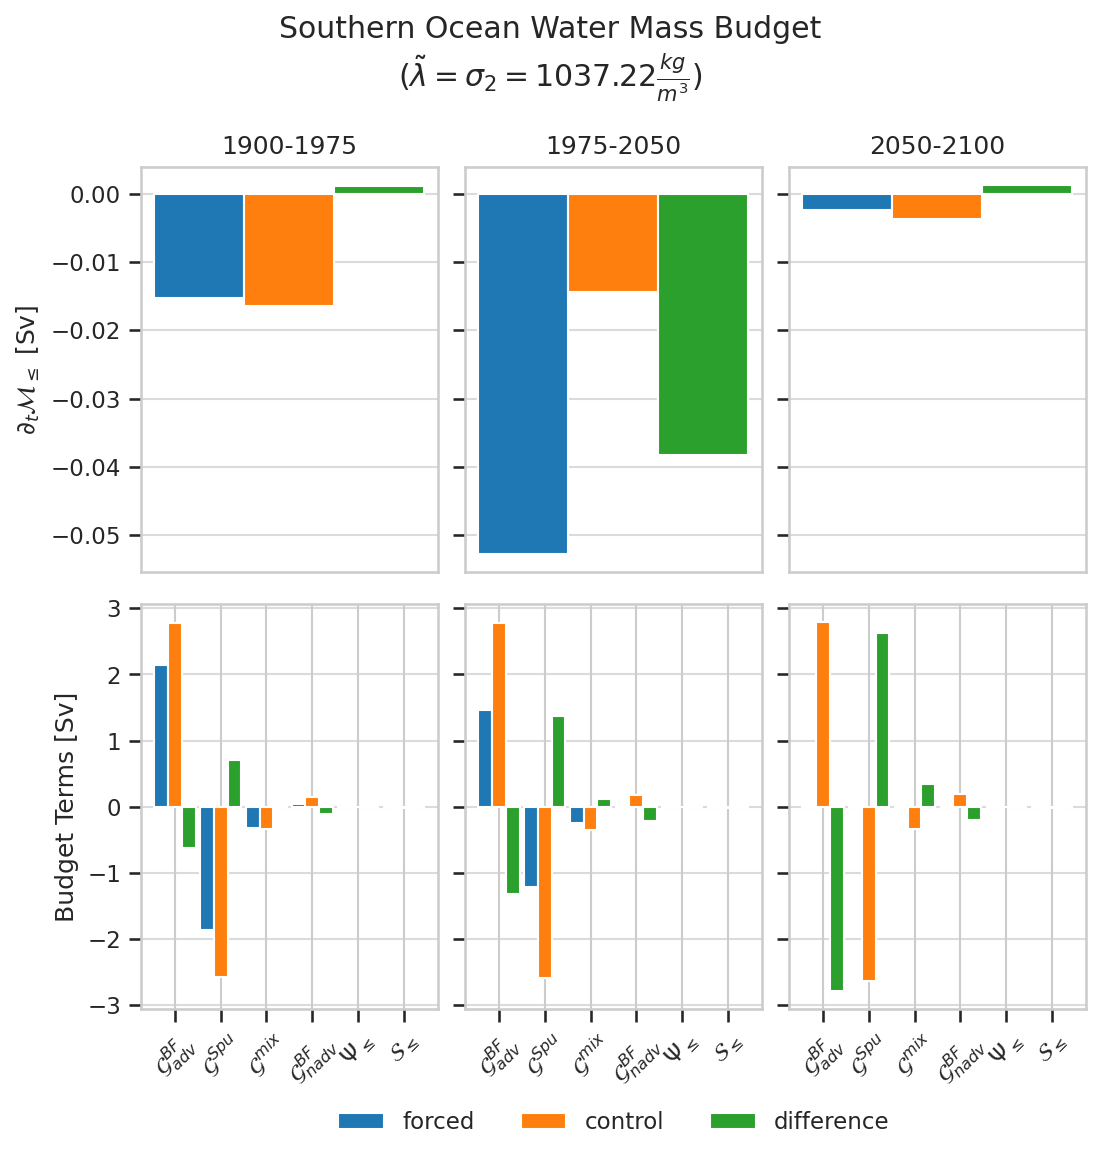

In [159]:
experiments = ['forced', 'control', 'difference']
nexpt = len(experiments)

budgets = ['mass_tendency', 
           'BF_Adv',
           'spurious_numerical_mixing',
           'diffusion', 
           'BF_NonAdv',
           'convergent_mass_transport', 
           'mass_source', 
           ]

budgets_labels = [r"$\partial_{t} \mathcal{M}_{\leq}$", 
                  r"$\mathcal{G}^{BF}_{adv}$",
                  r"$\mathcal{G}^{Spu}$",
                  r"$\mathcal{G}^{mix}$",
                  r"$\mathcal{G}^{BF}_{nadv}$",
                  r"$\Psi_{\leq}$", 
                  r"$\mathcal{S}_{\leq}$", 
                  ]



fig, ax = plt.subplots(2, 3, figsize = (7.5, 7.5),sharey = "row")
[a.grid(alpha = 0.7, axis = "y") for a in ax.flatten()]
width = 0.3

times = [("1900", "1975"), ("1975", "2050"), ("2050", "2100")]
for (it, t) in enumerate(times):
    wmt_mean = toSv * ds.sel(sigma2_l_target = 37.22, method = "nearest")
    wmt_mean = wmt_mean.sel(time = slice(t[0], t[1])).mean("time")
    difference = -wmt_mean.diff(dim = "exp")
    difference.coords['exp'] = ["difference"]
    wmt_mean = xr.merge([wmt_mean, difference])
    curr_width = 0.0
    ax[0, it].set_title('-'.join(t))
    for (i, exp) in enumerate(experiments):

        wmt_mean_budget =  wmt_mean.sel(exp = exp)
        print(wmt_mean_budget['mass_tendency'].values)
        bvalues = [wmt_mean_budget[k].values for k in budgets]
    
        ax[0, it].bar(0 + curr_width, bvalues[0], label = exp, width = width)
    
        nterms = np.arange(len(budgets_labels[1:]))
    
        ax[1, it].bar(nterms + curr_width, bvalues[1:], label = exp, width = width)
        curr_width += width
        if exp == "difference":
            curr_width += 2 * width
    
# [a.legend() for a in ax.flatten()]
[a.set_xticks([]) for a in ax[0, :]];
ax[0, 0].set_ylabel(budgets_labels[0] + " [Sv]")
ax[1, 0].set_ylabel("Budget Terms [Sv]")

[a.set_xticks(np.arange(len(budgets_labels[1:])) + width, budgets_labels[1:], rotation = 45) for a in ax[1, :]];
fig.suptitle("Southern Ocean Water Mass Budget\n" + r"$(\tilde \lambda = \sigma_2 = 1037.22 \frac{kg}{m^3})$")
fig.tight_layout()
ax[1, 1].legend(ncols = 3, bbox_to_anchor = (1.5, -0.2), frameon = False)
[a.tick_params(bottom=True, left=True) for a in ax.flatten()];

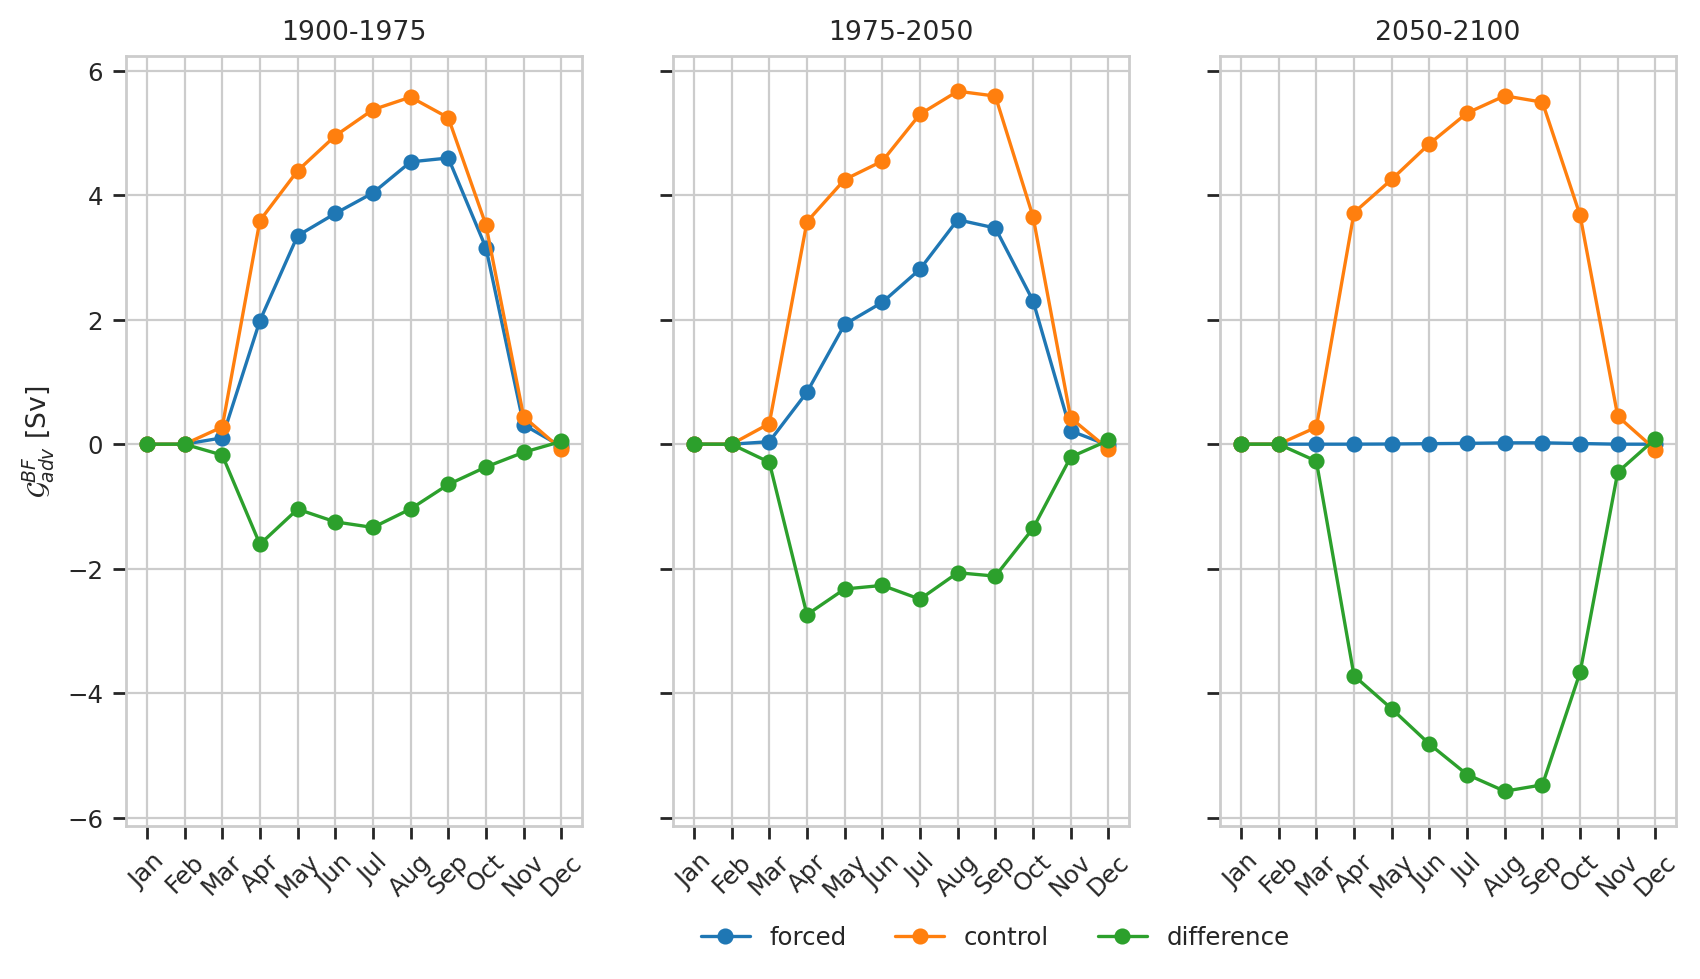

In [147]:
experiments = ['forced', 'control', 'difference']
nexpt = len(experiments)

fig, ax = plt.subplots(1, 3, figsize = (10, 5), sharey = "row")

width = 0.25
times = [("1900", "1975"), ("1975", "2050"), ("2050", "2100")]

for (it, t) in enumerate(times):
    wmt_mean = toSv * ds.sel(sigma2_l_target = 37.22, method = "nearest")
    wmt_mean = wmt_mean.sel(time = slice(t[0], t[1])).groupby("time.month").mean("time")
    difference = -wmt_mean.diff(dim = "exp")
    difference.coords['exp'] = ["difference"]
    wmt_mean = xr.merge([wmt_mean, difference])
    ax[it].set_title('-'.join(t))
    curr_width = 0.0
    for (i, exp) in enumerate(experiments):

        wmt_mean_budget =  wmt_mean.sel(exp = exp)["surface_ocean_flux_advective_negative_rhs"]
    
        ax[it].plot(wmt_mean_budget.month * 1.5, wmt_mean_budget, marker = "o", label = exp)

months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
ax[0].set_ylabel(r"$\mathcal{G}^{BF}_{adv}$" + " [Sv]")
ax[1].legend(ncols = 3, bbox_to_anchor = (1.4, -0.1), frameon = False)
[a.set_xticks(wmt_mean_budget.month * 1.5, months, rotation = 45) for a in ax];
[a.tick_params(bottom=True, left=True) for a in ax];


Text(0.5, 0, 'time')

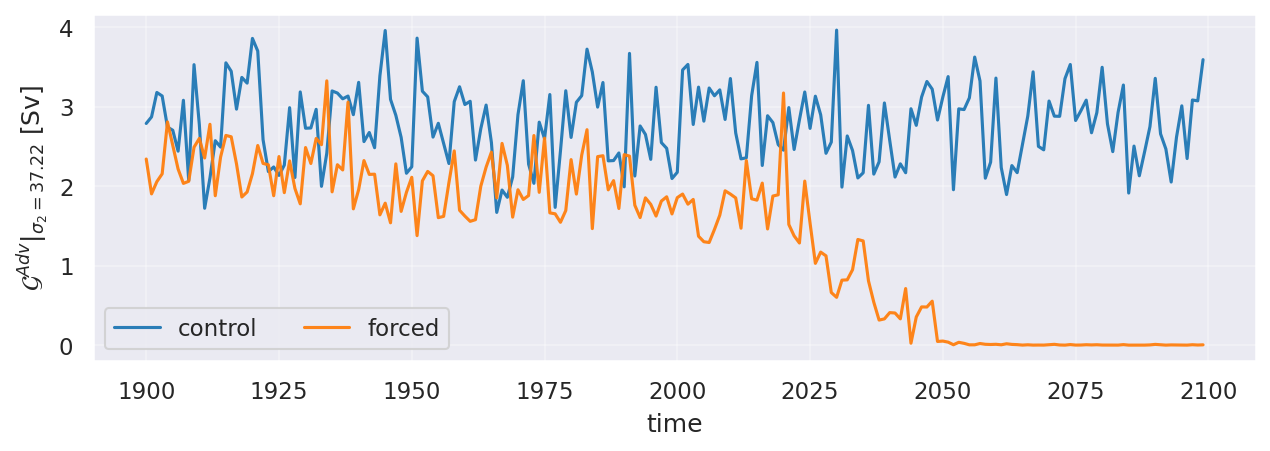

In [78]:
toSv = 1/1035*1e-6
tendencies = toSv * ds.sel(sigma2_l_target = 37.22, method = "nearest").compute()
tendencies = tendencies.groupby("time.year").mean("time")
tendencies = tendencies.sel(year = slice("1900", None))

fig, ax = plt.subplots(1, figsize = (10, 3))
ax.grid(alpha = 0.3)
ax.plot(tendencies.year, tendencies["surface_ocean_flux_advective_negative_rhs"].isel(exp = 1), label = "control", linewidth = 1.5, alpha = 0.95)
ax.plot(tendencies.year, tendencies["surface_ocean_flux_advective_negative_rhs"].isel(exp = 0), label = "forced", linewidth = 1.5, alpha = 0.95)
ax.legend(ncols = 2)

ax.set_ylabel(r"$\mathcal{G}^{Adv}|_{\sigma_2 = 37.22}$" + " [Sv]")
ax.set_xlabel("time")

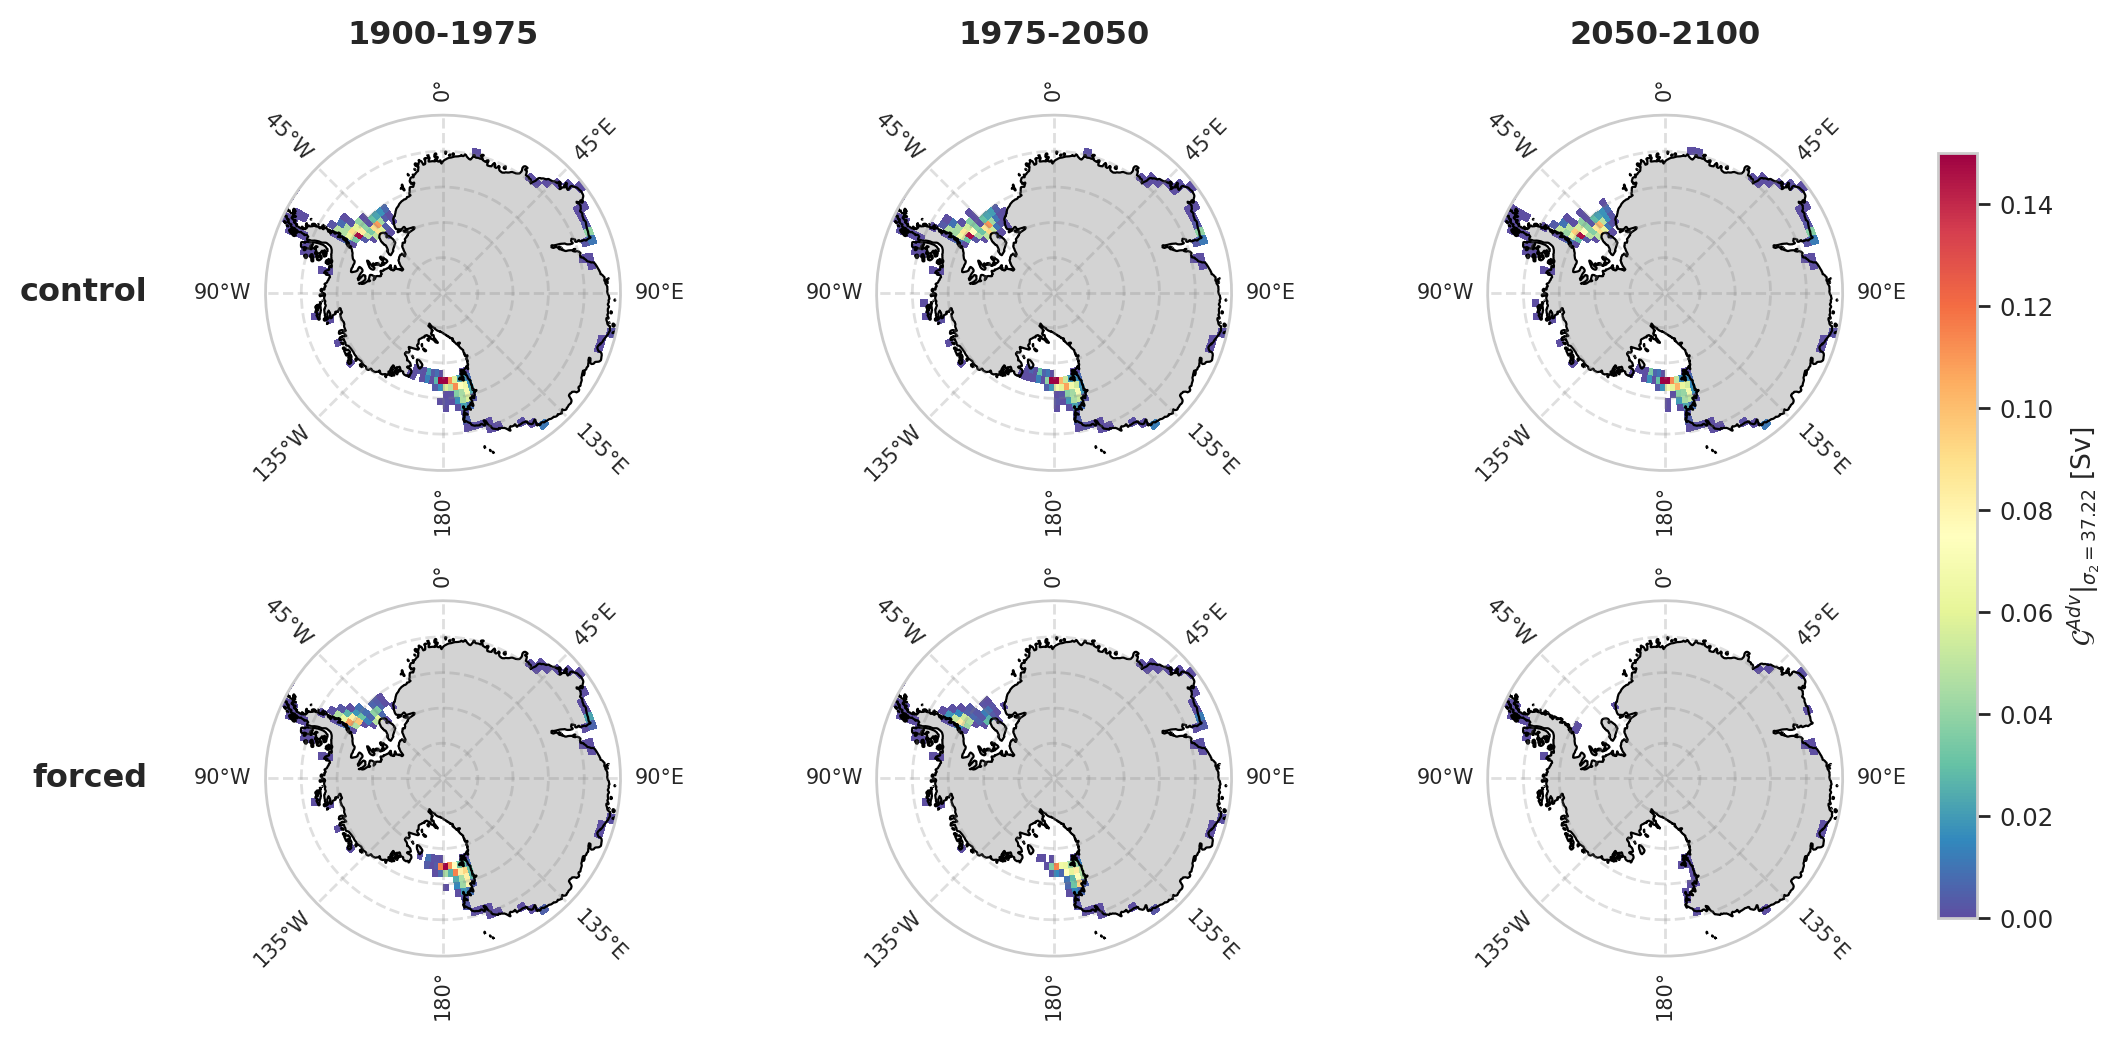

In [146]:
import matplotlib.patches as  mpath

experiments = ['control', 'forced']
nexpt = len(experiments)
import cartopy.feature as cfeature
sns.set_style("whitegrid")
sns.set_context("paper")
mpl.rcParams['figure.dpi'] = 200

fig, ax = plt.subplots(2, 3, figsize = (10, 5),
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})
[a.set_extent([-180, 180, -90, -65], ccrs.PlateCarree()) for a in ax.flatten()]
width = 0.25
times = [("1900", "1975"), ("1975", "2050"), ("2050", "2100")]

for (it, t) in enumerate(times):
    wmt_mean = ds_sfc.sel(time = slice(t[0], t[1])).mean("time")
    curr_width = 0.0
    for (i, exp) in enumerate(experiments):

        wmt_mean_budget =  toSv * wmt_mean.sel(exp = exp)["surface_ocean_flux_advective_negative_rhs"]
        wmt_mean_budget = wmt_mean_budget.where(wmt_mean_budget != 0.0)
        cm = ax[i, it].pcolormesh(wmt_mean_budget.geolon, wmt_mean_budget.geolat, 
                             wmt_mean_budget, cmap = "Spectral_r", transform=ccrs.PlateCarree(), 
                            vmin = 0.0, vmax = 0.15)
        # ax[i, it].set_title(exp + '\n' + '-'.join(t), fontsize = 10)
        ax[i, it].coastlines();
        ax[i, it].add_feature(cfeature.LAND, facecolor='lightgrey')

        # Draw meridian lines with labels around circular boundary
        ax[i, it].gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, \
                        xlocs=range(-180,171,45), ylocs=[], \
                        color='gray', alpha=0.25, linestyle='--', zorder=10, 
                        xlabel_style = {"fontsize":7.5})
        # Draw concentric circles (but hide labels) for the parallels of the latitude
        ax[i, it].gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, \
                        xlocs=[], ylocs=None, \
                        color='gray', alpha=0.25, linestyle='--', zorder=10)
        # Add circular boundary
        theta = np.linspace(0, 2*np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)
        
        ax[i, it].set_boundary(circle, transform=ax[i, it].transAxes)


fig.tight_layout()

for a, col in zip(ax[0], times):
    a.annotate('-'.join(col), xy=(0.5, 1.2), xytext=(0, 0.05),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline', fontweight = "bold")

for a, row in zip(ax[:,0], experiments):
    a.annotate(row, xy=(-.3, 0.5), xytext=(-a.yaxis.labelpad - 0.05, 0),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='right', va='center', fontweight = "bold")
    
fig.colorbar(cm, ax = ax[:, :], label = r"$\mathcal{G}^{Adv}|_{\sigma_2 = 37.22}$" + " [Sv]", fraction = 0.02)